In [84]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage

import io
import xarray as xr

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (40., 40.)
%matplotlib inline

In [83]:
cd ..

/home/ck


In [85]:
cmip_models = ['MPI-ESM1-2-LR', 'CESM2', 'IPSL-CM6A-LR', 'EC-Earth3', 'CNRM-CM6-1']#, 'EC-Earth3']

In [86]:
experiments = { 'amip-lfmip-rmLC_hist' : (1980,2007), 'amip-lfmip-rmLC_fut' : (2080,2101), 'amip-lfmip-pdLC_hist' : (1980,2007), 'amip-lfmip-pdLC_fut' : (2080,2101)}

In [8]:
def get_month(mtag, experiments):
    
    struc = {}
    
    pup = 60000
    pdown = 92500
    months = mtag
    
    for exp in experiments:
    
#         exp ='historical'
        tas_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/tas_*'+months+'*.nc', concat_dim='model', combine='nested').load()-273.15
        uuah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/ua_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=slice(92500,60000)).load()
        uvah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/va_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=slice(92500,60000)).load()
        uah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/ua_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pup).load()
        vah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/va_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pup).load()
        ual_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/ua_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pdown).load()
        val_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/va_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pdown).load()
        sh_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/hfss_*'+months+'*.nc', concat_dim='model', combine='nested').load()
        lh_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/hfls_*'+months+'*.nc', concat_dim='model', combine='nested').load()
        psl_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/psl_*'+months+'*.nc', concat_dim='model', combine='nested').load()
        
       # ipdb.set_trace()
        
        uushear_hist = uuah_hist['ua'].max('plev') - uuah_hist['ua'].min('plev')
        vvshear_hist = uvah_hist['va'].max('plev') - uvah_hist['va'].min('plev')
        maxshear = np.sqrt(uushear_hist**2+vvshear_hist**2)
        
        maxshear_sign = maxshear.copy()
        maxshear_sign.values[uushear_hist<0] = maxshear_sign.values[uushear_hist<0]*-1
        
        ef_hist = lh_hist['hfls'] / (lh_hist['hfls']+sh_hist['hfss'])
        prw_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/prw_*.nc', concat_dim='model', combine='nested').load()
        
        ushear_hist = uah_hist['ua'] - ual_hist['ua']
        vshear_hist = vah_hist['va'] - val_hist['va']
        
        wsl = np.sqrt(ual_hist['ua']**2+val_hist['va']**2)
        wsh = np.sqrt(uah_hist['ua']**2+vah_hist['va']**2)
        
        grad = np.gradient(tas_hist['tas'])
        grad_ar = tas_hist['tas'].copy(deep=True)
        
        ngrad = grad[1]
        lon, lat = np.meshgrid(grad_ar.lon, grad_ar.lat)
        pos = np.where(lat<0)
        ngrad[:, pos[0], pos[1]] = ngrad[:, pos[0], pos[1]]*-1
        
        grad_ar.values = ngrad
        
        #grad_ar = grad_ar.rename({'tas':'tgrad'})
        
        #ipdb.set_trace()
        
        struc[exp] = {'tas' : u_darrays.roll_lons(tas_hist['tas']),
                      'uah' : u_darrays.roll_lons(uah_hist['ua']),
                      'vah' : u_darrays.roll_lons(vah_hist['va']),
                      'ual' : u_darrays.roll_lons(ual_hist['ua']),
                      'val' : u_darrays.roll_lons(val_hist['va']),
                      'sh' : u_darrays.roll_lons(sh_hist['hfss']),
                      'lh' : u_darrays.roll_lons(lh_hist['hfls']),
                      'ushear' : u_darrays.roll_lons(ushear_hist),
                      'vshear' : u_darrays.roll_lons(vshear_hist),
                      'ushear_max' : u_darrays.roll_lons(uushear_hist),
                      'vshear_max' : u_darrays.roll_lons(vvshear_hist),
                      'shear' : u_darrays.roll_lons(maxshear),
                      'shear_sign' : u_darrays.roll_lons(maxshear_sign),
                      'ef' : u_darrays.roll_lons(ef_hist),
                      'slp' : u_darrays.roll_lons(psl_hist['psl']),
                      'wsl' : u_darrays.roll_lons(wsl),
                      'wsh' : u_darrays.roll_lons(wsh),
                      'tgrad' : u_darrays.roll_lons(grad_ar),
                      'prw' : u_darrays.roll_lons(prw_hist['prw'])}
        
    return struc

In [9]:
DJF_struc = get_month('NDJFM', experiments)
JJA_struc = get_month('MJJAS', experiments)

In [10]:
DJF_struc['amip-lfmip-rmLC_fut'].keys()

dict_keys(['tas', 'uah', 'vah', 'ual', 'val', 'sh', 'lh', 'ushear', 'vshear', 'ushear_max', 'vshear_max', 'shear', 'shear_sign', 'ef', 'slp', 'wsl', 'wsh', 'tgrad', 'prw'])

In [12]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, clabel='', cmap='RdBu_r'):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'],width=0.0005, headwidth=7)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='Turquoise', linewidths=0.5 )
        #plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [20]:
def get_var(VAR, mtag):

    ename = list(experiments.keys())
    latbox = [-45,45]
    
    if mtag == 'JJA':
        instruc = JJA_struc
    if mtag == 'SON':
        instruc = SON_struc
    if mtag == 'MAM':
        instruc = MAM_struc
    if mtag == 'DJF':
        instruc = DJF_struc

    hist = (instruc[ename[0]][VAR]).mean('model').sel(lat=slice(latbox[0], latbox[1]))
    fut = (instruc[ename[1]][VAR]).mean('model').sel(lat=slice(latbox[0], latbox[1]))
    ahist = (instruc[ename[2]][VAR]).mean('model').sel(lat=slice(latbox[0], latbox[1]))
    afut = (instruc[ename[3]][VAR]).mean('model').sel(lat=slice(latbox[0], latbox[1]))
    
    return hist, fut, ahist, afut

In [21]:
def get_var_model(VAR, mtag,model):

    ename = list(experiments.keys())
    latbox = [-45,45]
    
    if mtag == 'JJA':
        instruc = JJA_struc
    if mtag == 'SON':
        instruc = SON_struc
    if mtag == 'MAM':
        instruc = MAM_struc
    if mtag == 'DJF':
        instruc = DJF_struc
    
    hist = (instruc[ename[0]][VAR]).isel(model=model).sel(lat=slice(latbox[0], latbox[1]))
    fut = (instruc[ename[1]][VAR]).isel(model=model).sel(lat=slice(latbox[0], latbox[1]))
    ahist = (instruc[ename[2]][VAR]).isel(model=model).sel(lat=slice(latbox[0], latbox[1]))
    afut = (instruc[ename[3]][VAR]).isel(model=model).sel(lat=slice(latbox[0], latbox[1]))
    
    return hist, fut, ahist, afut

In [80]:
shear_diff = []
shs_diff = []

for mtag in [('SON', 'SON'), ('JJA', 'JJA')]:

    hist, fut, ahist, afut = get_var('tas', mtag[0])
    hist2, fut2, ahist2, afut2 = get_var('tas', mtag[1])
    shdiff =  xr.concat([(fut-afut), (fut2-afut2)], dim='ix').mean('ix')
    shs_diff.append(shdiff)
    
    hist, fut, ahist, afut = get_var('shear', mtag[0])
    hist2, fut2, ahist2, afut2 = get_var('shear', mtag[1])
    sheardiff = xr.concat([(fut-afut), (fut2-afut2)], dim='ix').mean('ix')
    shear_diff.append(sheardiff)

In [81]:
shear_merge = shear_diff[1].copy(deep=True)
sh_merge = shs_diff[1].copy(deep=True)
lon, lat = np.meshgrid(shear_merge.lon, shear_merge.lat)
shear_merge.values[lat<0] = shear_diff[0].values[lat<0]
sh_merge.values[lat<0] = shs_diff[0].values[lat<0]

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


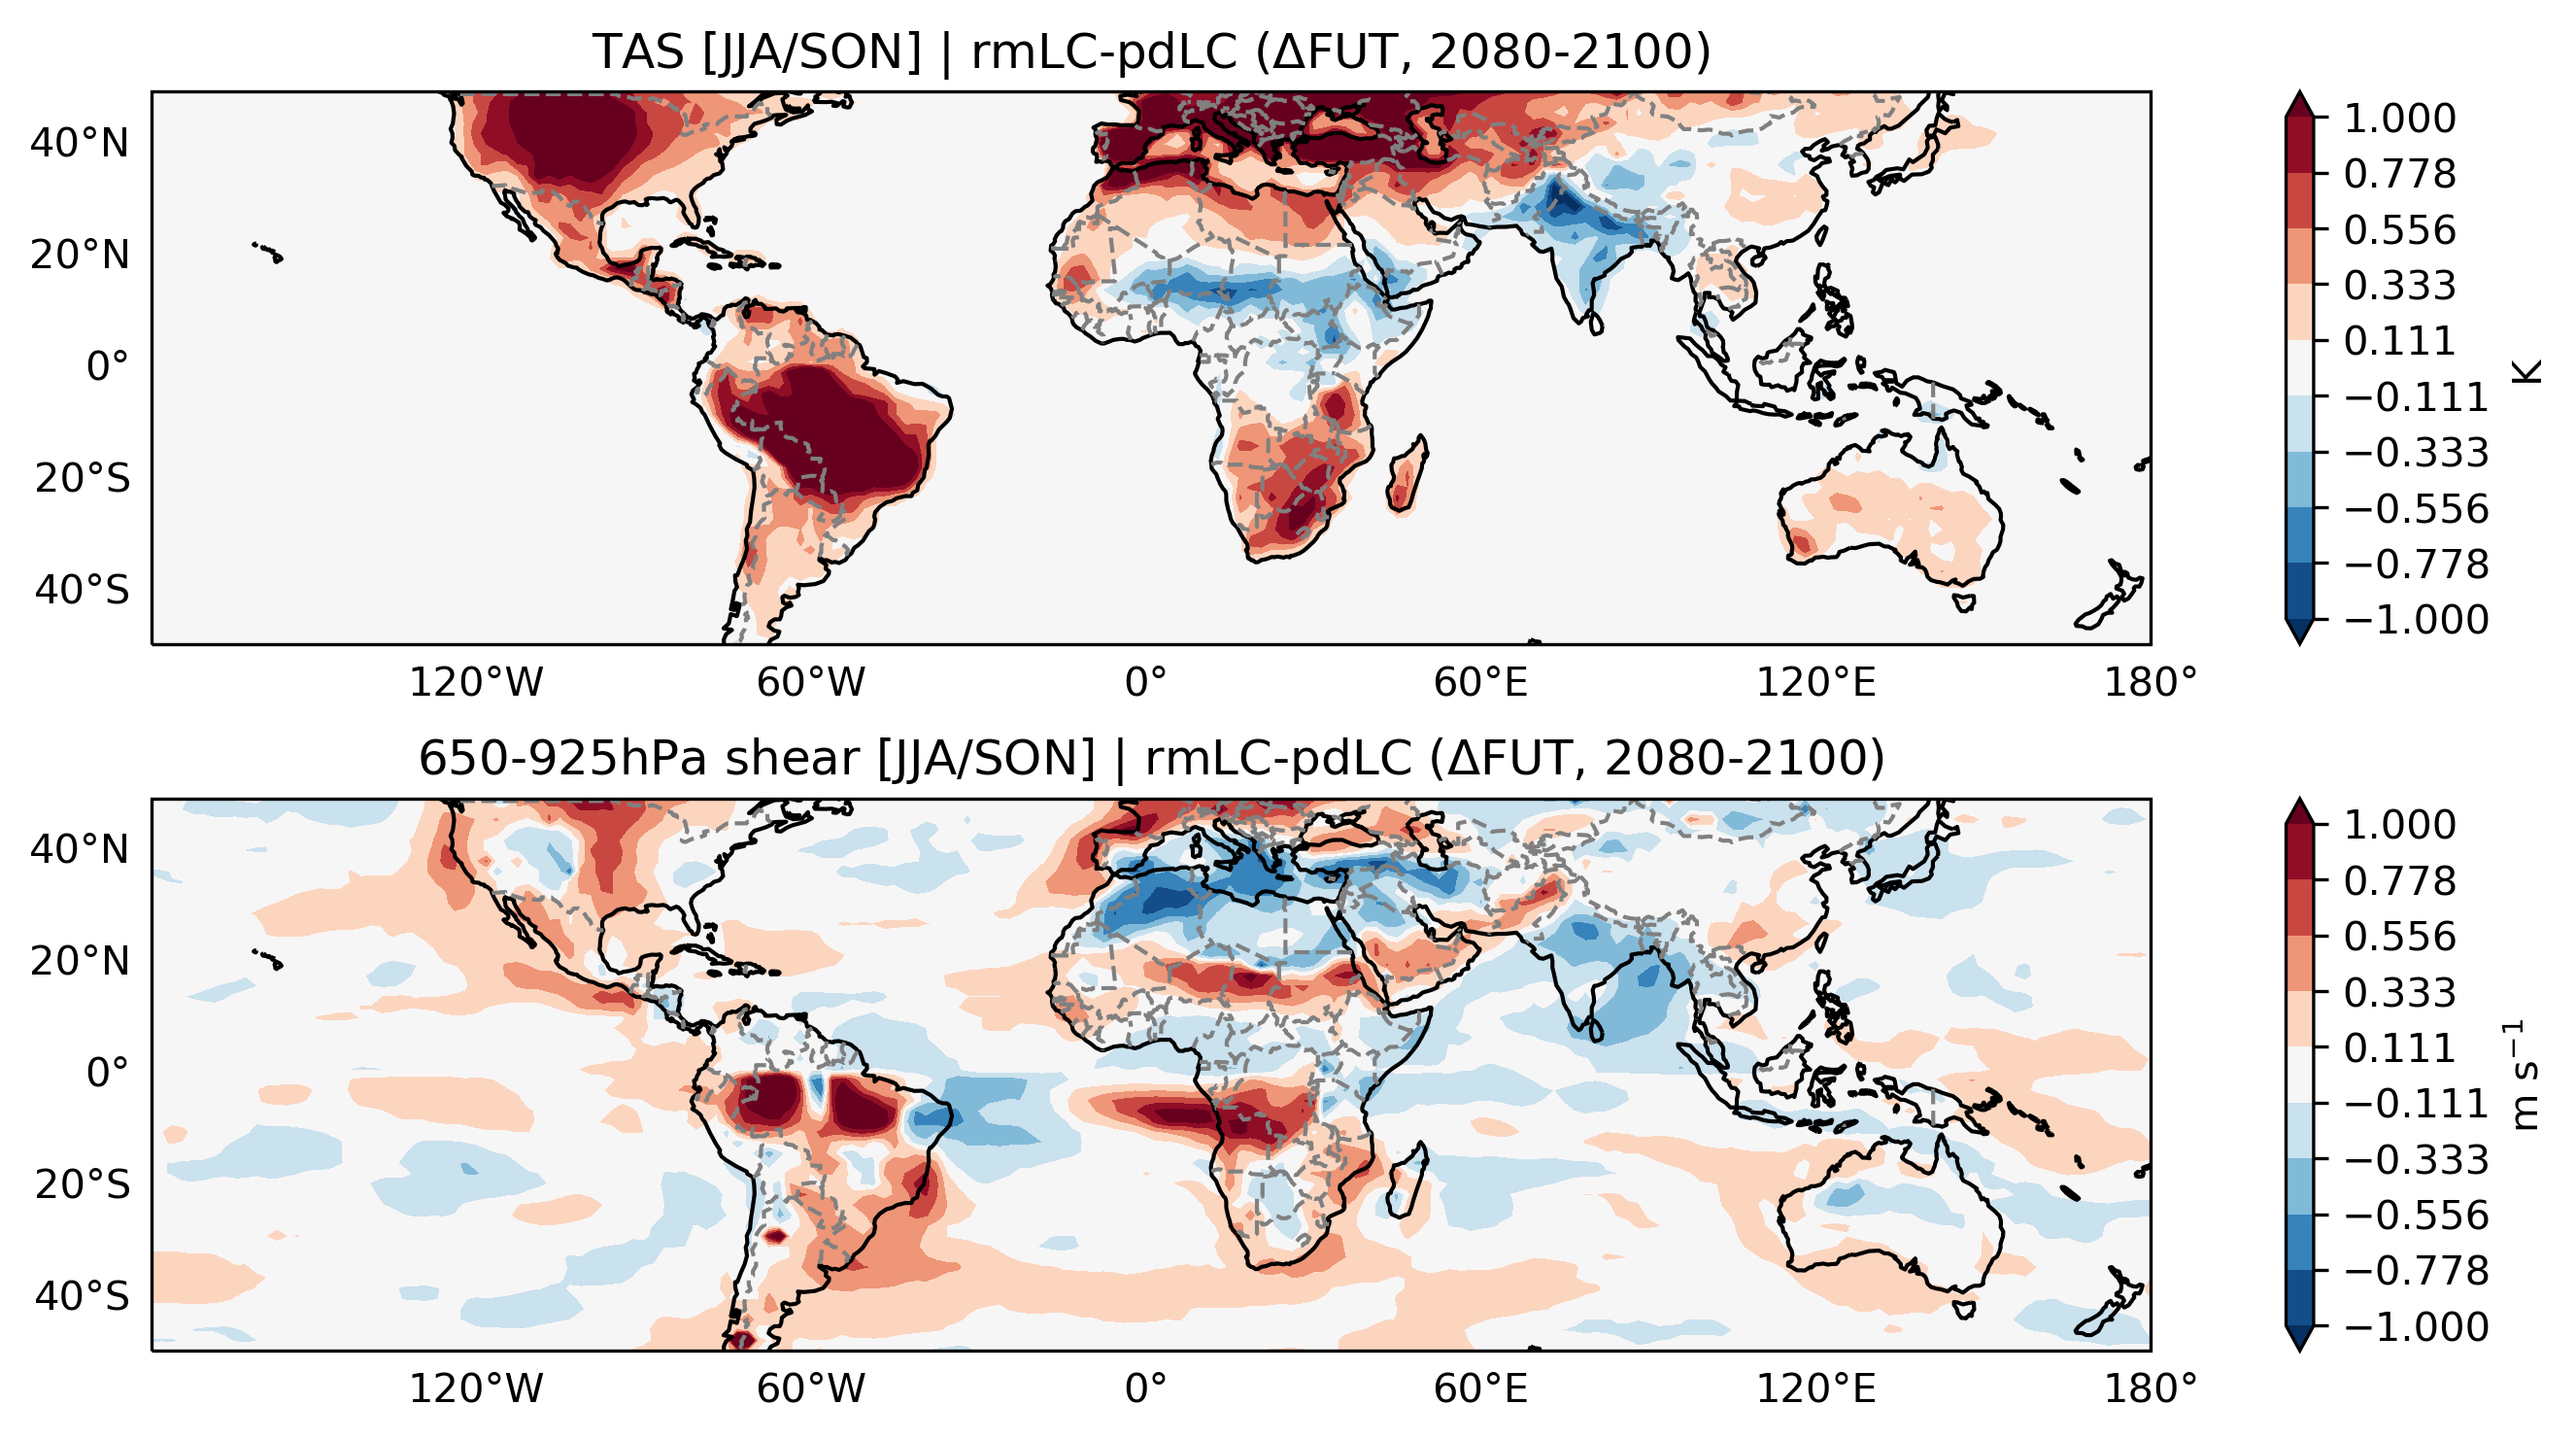

In [82]:

f = plt.figure(figsize=(10,5), dpi=300)

ax = f.add_subplot(211, projection=ccrs.PlateCarree())
draw_map(ax, sh_merge,sh_merge.lat, sh_merge.lon, title='TAS [JJA/SON] | rmLC-pdLC ($\Delta$FUT, 2080-2100)', levels=np.linspace(-1,1,10), clabel='K') #np.percentile(k, np.arange(5,91,11) 'W m$^{-2}$'

ax = f.add_subplot(212, projection=ccrs.PlateCarree())
draw_map(ax, shear_merge,shear_merge.lat, shear_merge.lon, title='650-925hPa shear [JJA/SON] | rmLC-pdLC ($\Delta$FUT, 2080-2100)', levels=np.linspace(-1,1,10), clabel='m s$^{-1}$') #np.percentile(k, np.arange(5,91,11)

f.canvas.draw()
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/TAS-SHEAR_rmLC-vs-pdLC_mergeMAP.jpg')

In [87]:
MREGIONS = {
 'GPlains_N' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-99,-96,42,44], 'GPlains', 'JJA'], # # 18
 'GPlains_S' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-98,-95,36,39], 'GPlains', 'JJA'], # # 18
 'china_W' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [105,107,29,31], 'china', 'JJA'], # 4
 'china_E' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [111,113,25,27], 'china', 'JJA'], # 4
 'india_N' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [74,76,24,26], 'india', 'JJA'], # 7
 'india_S' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [76,79,18,21], 'india', 'JJA'], # 7
 'WAf_N' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,14,16], 'WAf', 'JJA'], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'WAf_S' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,7,9], 'WAf', 'JJA'],
 'australia_S' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -21,-18], 'australia', 'DJF'], # 3
 'australia_N' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -17,-15], 'australia', 'DJF'],
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (1,5), (1,12), [21,24.5,-28,-24], 'SAf', 'DJF'], # 10
 'sub_SA_S' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-33,-30], 'sub_SA', 'DJF'],  # 16
 'sub_SA_N' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-28,-22], 'sub_SA', 'DJF']  # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17

}
S_REGION = 'china_W'
REGION = MREGIONS[S_REGION][7]

0.2524655676577963


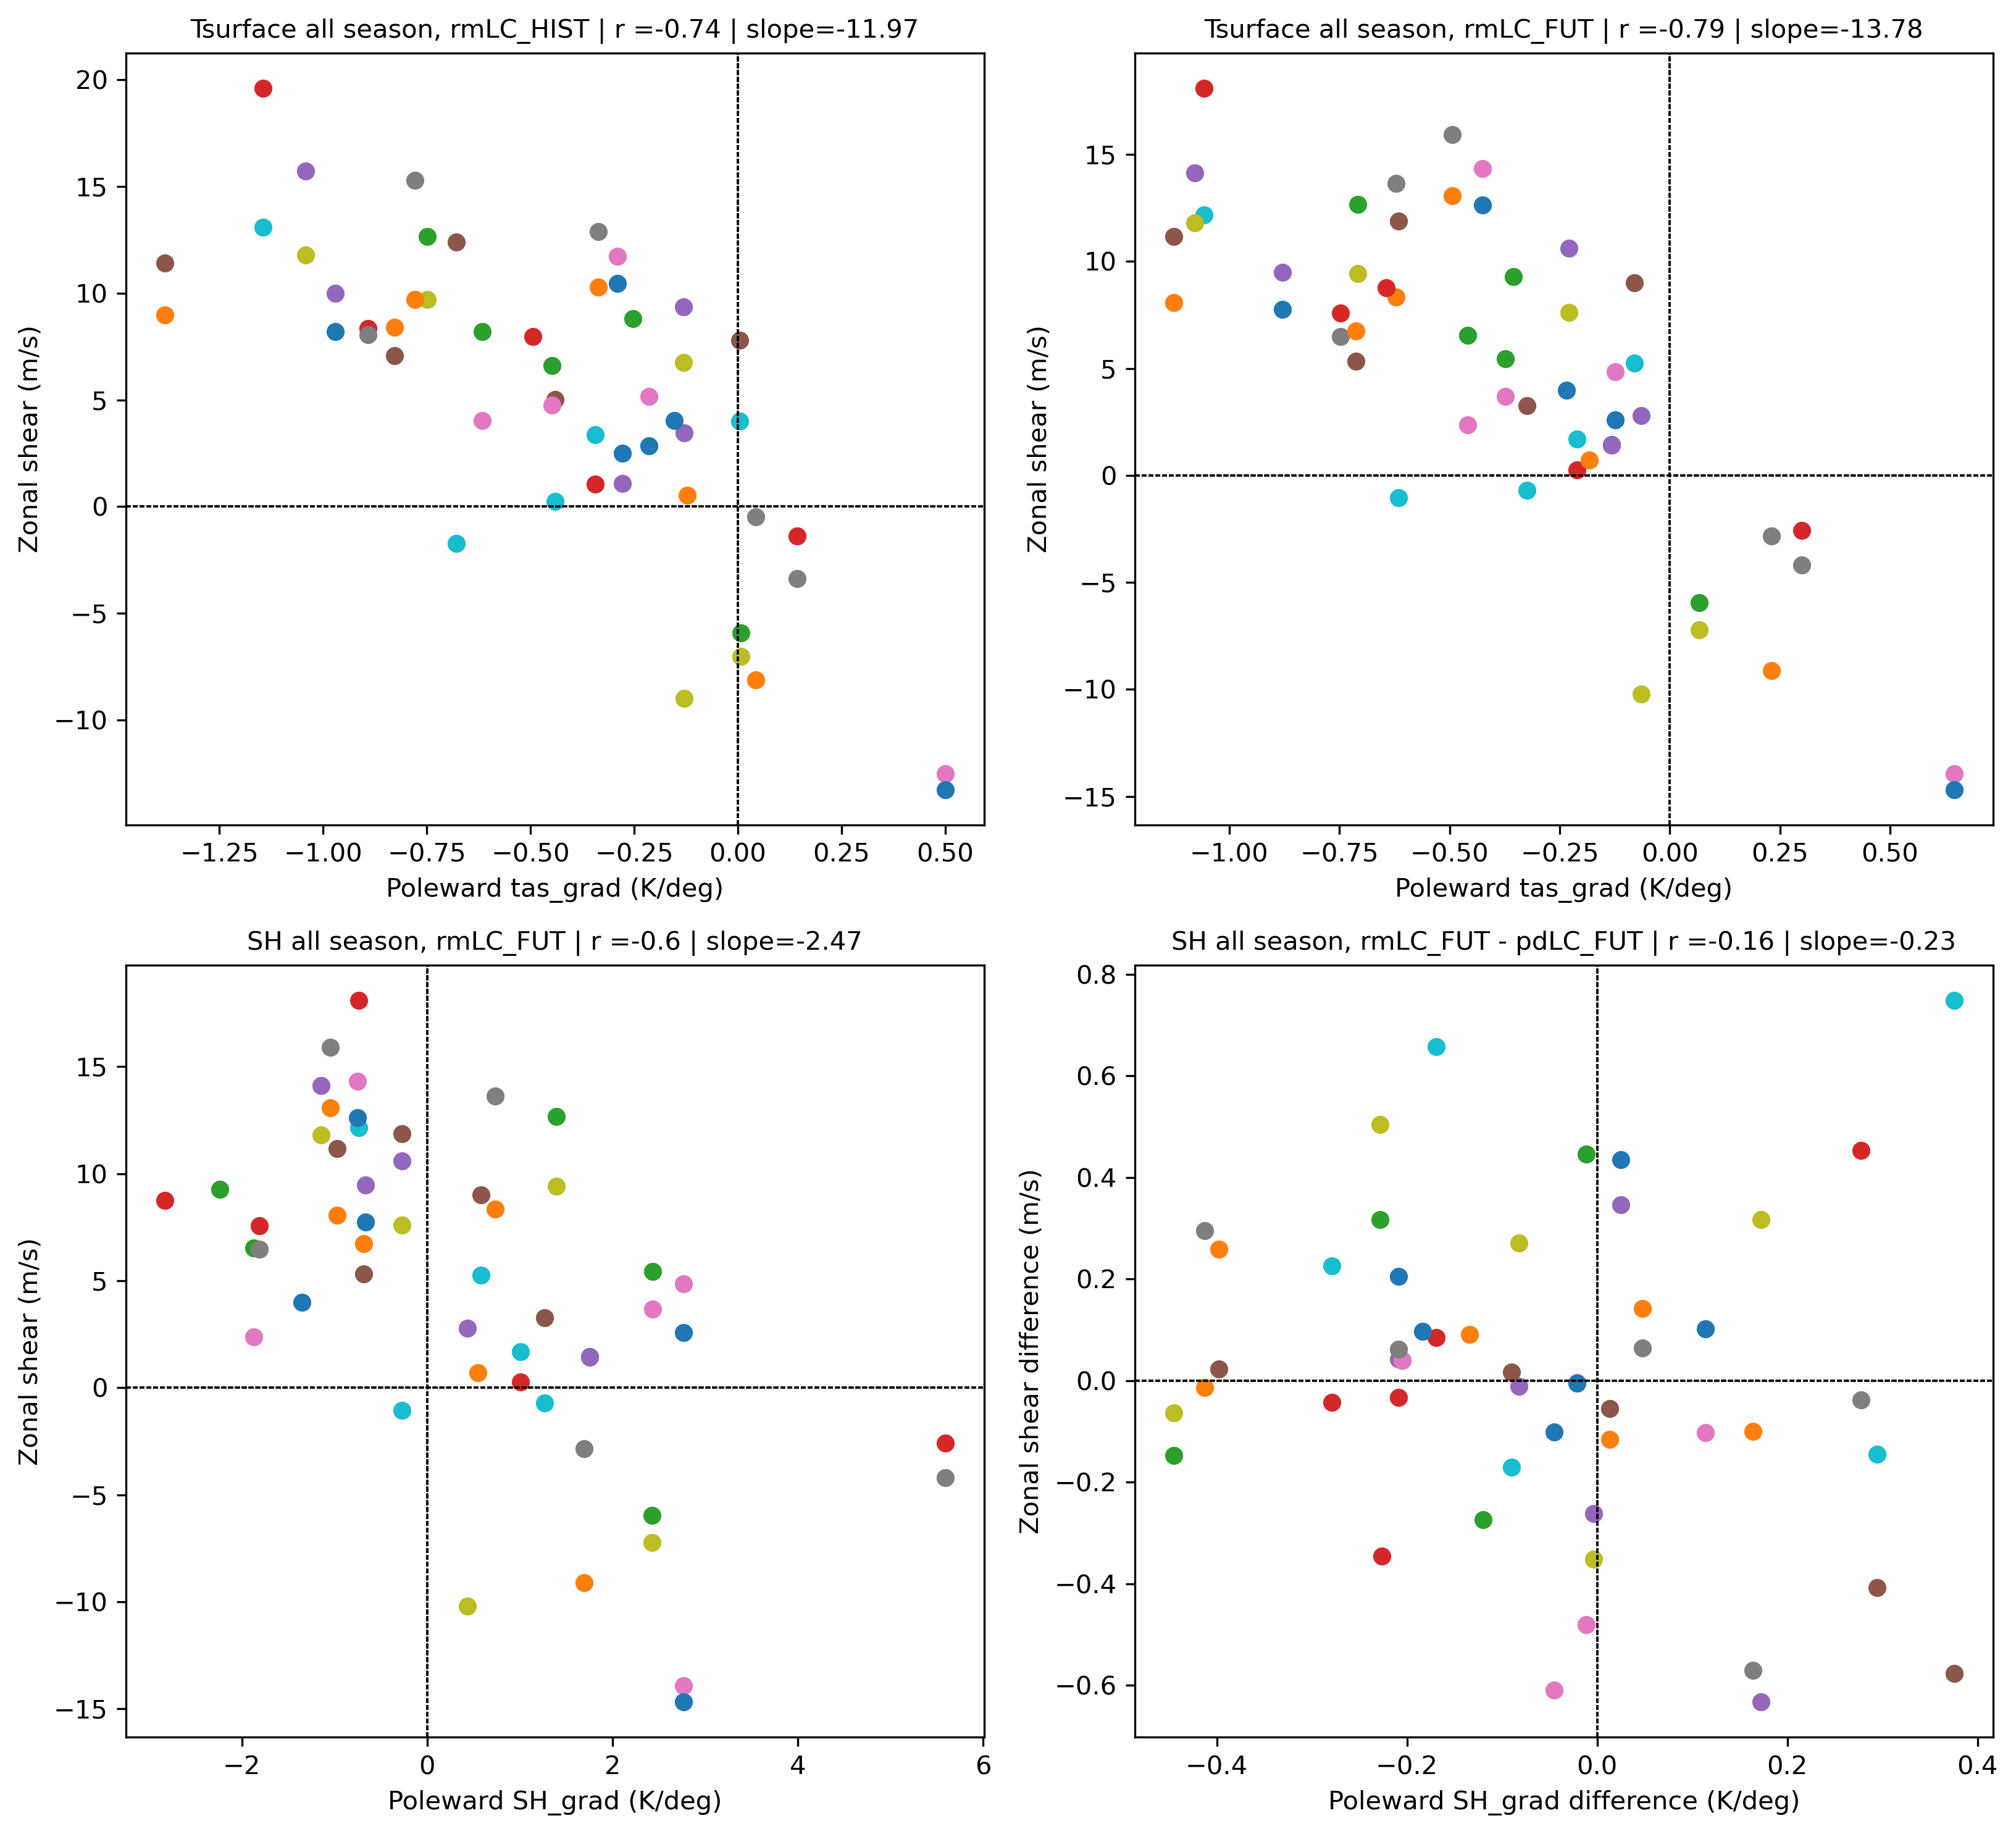

In [264]:
f = plt.figure(figsize=(11,10), dpi=300)


colors = ['red', 'orange', 'gold', 'brown', 'blue', 'purple', 'violet']
lss = ['solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'dashed']

# for idx, seas in enumerate(['MAM', 'JJA', 'SON', 'DJF']):

tgrad_list = []
shear_list = []
ax = f.add_subplot(221)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
    for mtag in ['MAM', 'DJF', 'JJA', 'SON']:
        
        VAR1='tas'
        VAR2='ushear'
        
        hist, fut, ahist, afut = get_var(VAR1, mtag)
        hist2, fut2, ahist2, afut2 = get_var(VAR2, mtag)

        era_t = hist#-afut
        era_ushear = hist2#-afut2


        box = MREGIONS[reg][6]
        lbox = MREGIONS[reg][0]

        erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
        erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
        
        if ids >= 8:
            erat_poly = erat_poly*-1

#         if ids >= 8:
#             erashear_box = erashear_box*-1
        
        ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
        ax.set_xlabel('Poleward tas_grad (K/deg)')
        ax.set_ylabel('Zonal shear (m/s)')
        ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
        ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)

        tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
        shear_list.append(erashear_box.values)
#rval, pval = stats.pearsonr(tgrad_list, shear_list)
pf, intercept, rval, p, std_err = stats.linregress(tgrad_list, shear_list)
plt.title('Tsurface all season, rmLC_HIST | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2))+'', fontsize=10)
#stats.linregress(tgrad_list, shear_list)

tgrad_list = []
shear_list = []
ax = f.add_subplot(222)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    for mtag in ['MAM', 'DJF', 'JJA', 'SON']:
    
        
        VAR1='tas'
        VAR2='ushear'
        
        hist, fut, ahist, afut = get_var(VAR1, mtag)
        hist2, fut2, ahist2, afut2 = get_var(VAR2, mtag)

        era_t = afut
        era_ushear = afut2


        box = MREGIONS[reg][6]
        lbox = MREGIONS[reg][0]

        erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
        erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
        
        if ids >= 8:
            erat_poly = erat_poly*-1
#         if ids >= 8:
#             erashear_box = erashear_box*-1
        
        ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
        ax.set_xlabel('Poleward tas_grad (K/deg)')
        ax.set_ylabel('Zonal shear (m/s)')
        ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
        ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
        tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
        shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(tgrad_list, shear_list)
plt.title('Tsurface all season, rmLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2))+'', fontsize=10) 


tgrad_list = []
shear_list = []
ax = f.add_subplot(223)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
    for mtag in ['MAM', 'DJF', 'JJA', 'SON']:    

        
        VAR1='sh'
        VAR2='ushear'
        
        hist, fut, ahist, afut = get_var(VAR1, mtag)
        hist2, fut2, ahist2, afut2 = get_var(VAR2, mtag)

        era_t = afut
        era_ushear = afut2


        box = MREGIONS[reg][6]
        lbox = MREGIONS[reg][0]

        erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
        erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
        #ipdb.set_trace()
        
        if ids >= 8:
            erat_poly = erat_poly*-1
            
#         if ids >= 8:
#             erashear_box = erashear_box*-1
        
        ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
        ax.set_xlabel('Poleward SH_grad (K/deg)')
        ax.set_ylabel('Zonal shear (m/s)')
        ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
        ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
        tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
        shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(tgrad_list, shear_list)
plt.title('SH all season, rmLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 


tgrad_list = []
shear_list = []
ax = f.add_subplot(224)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
    for mtag in ['MAM', 'DJF', 'JJA', 'SON']:    

        
        VAR1='sh'
        VAR2='ushear'
        
        hist, fut, ahist, afut = get_var(VAR1, mtag)
        hist2, fut2, ahist2, afut2 = get_var(VAR2, mtag)

        era_t = fut-afut
        era_ushear = fut2-afut2


        box = MREGIONS[reg][6]
        lbox = MREGIONS[reg][0]

        erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
        erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
        #ipdb.set_trace()
        
        if ids >= 8:
            erat_poly = erat_poly*-1
            
#         if ids >= 8:
#             erashear_box = erashear_box*-1
        #ipdb.set_trace()
        erashear_box.values[erashear_box>1.5] = -0.1
        
        ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
        ax.set_xlabel('Poleward SH_grad difference (K/deg)')
        ax.set_ylabel('Zonal shear difference (m/s)')
        ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
        ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
        tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
        shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(tgrad_list, shear_list)
plt.title('SH all season, rmLC_FUT - pdLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 
print(p)

plt.tight_layout()
#f.savefig(cnst.FIGS+'/LMCS/CMIP_LS3MIP/LS3MIP-rmLC-pdLC/relationships_scatter/CMIP_shear_Tgradient_relationship_climMean_allMonths.jpg')

3.0093493096146986e-09


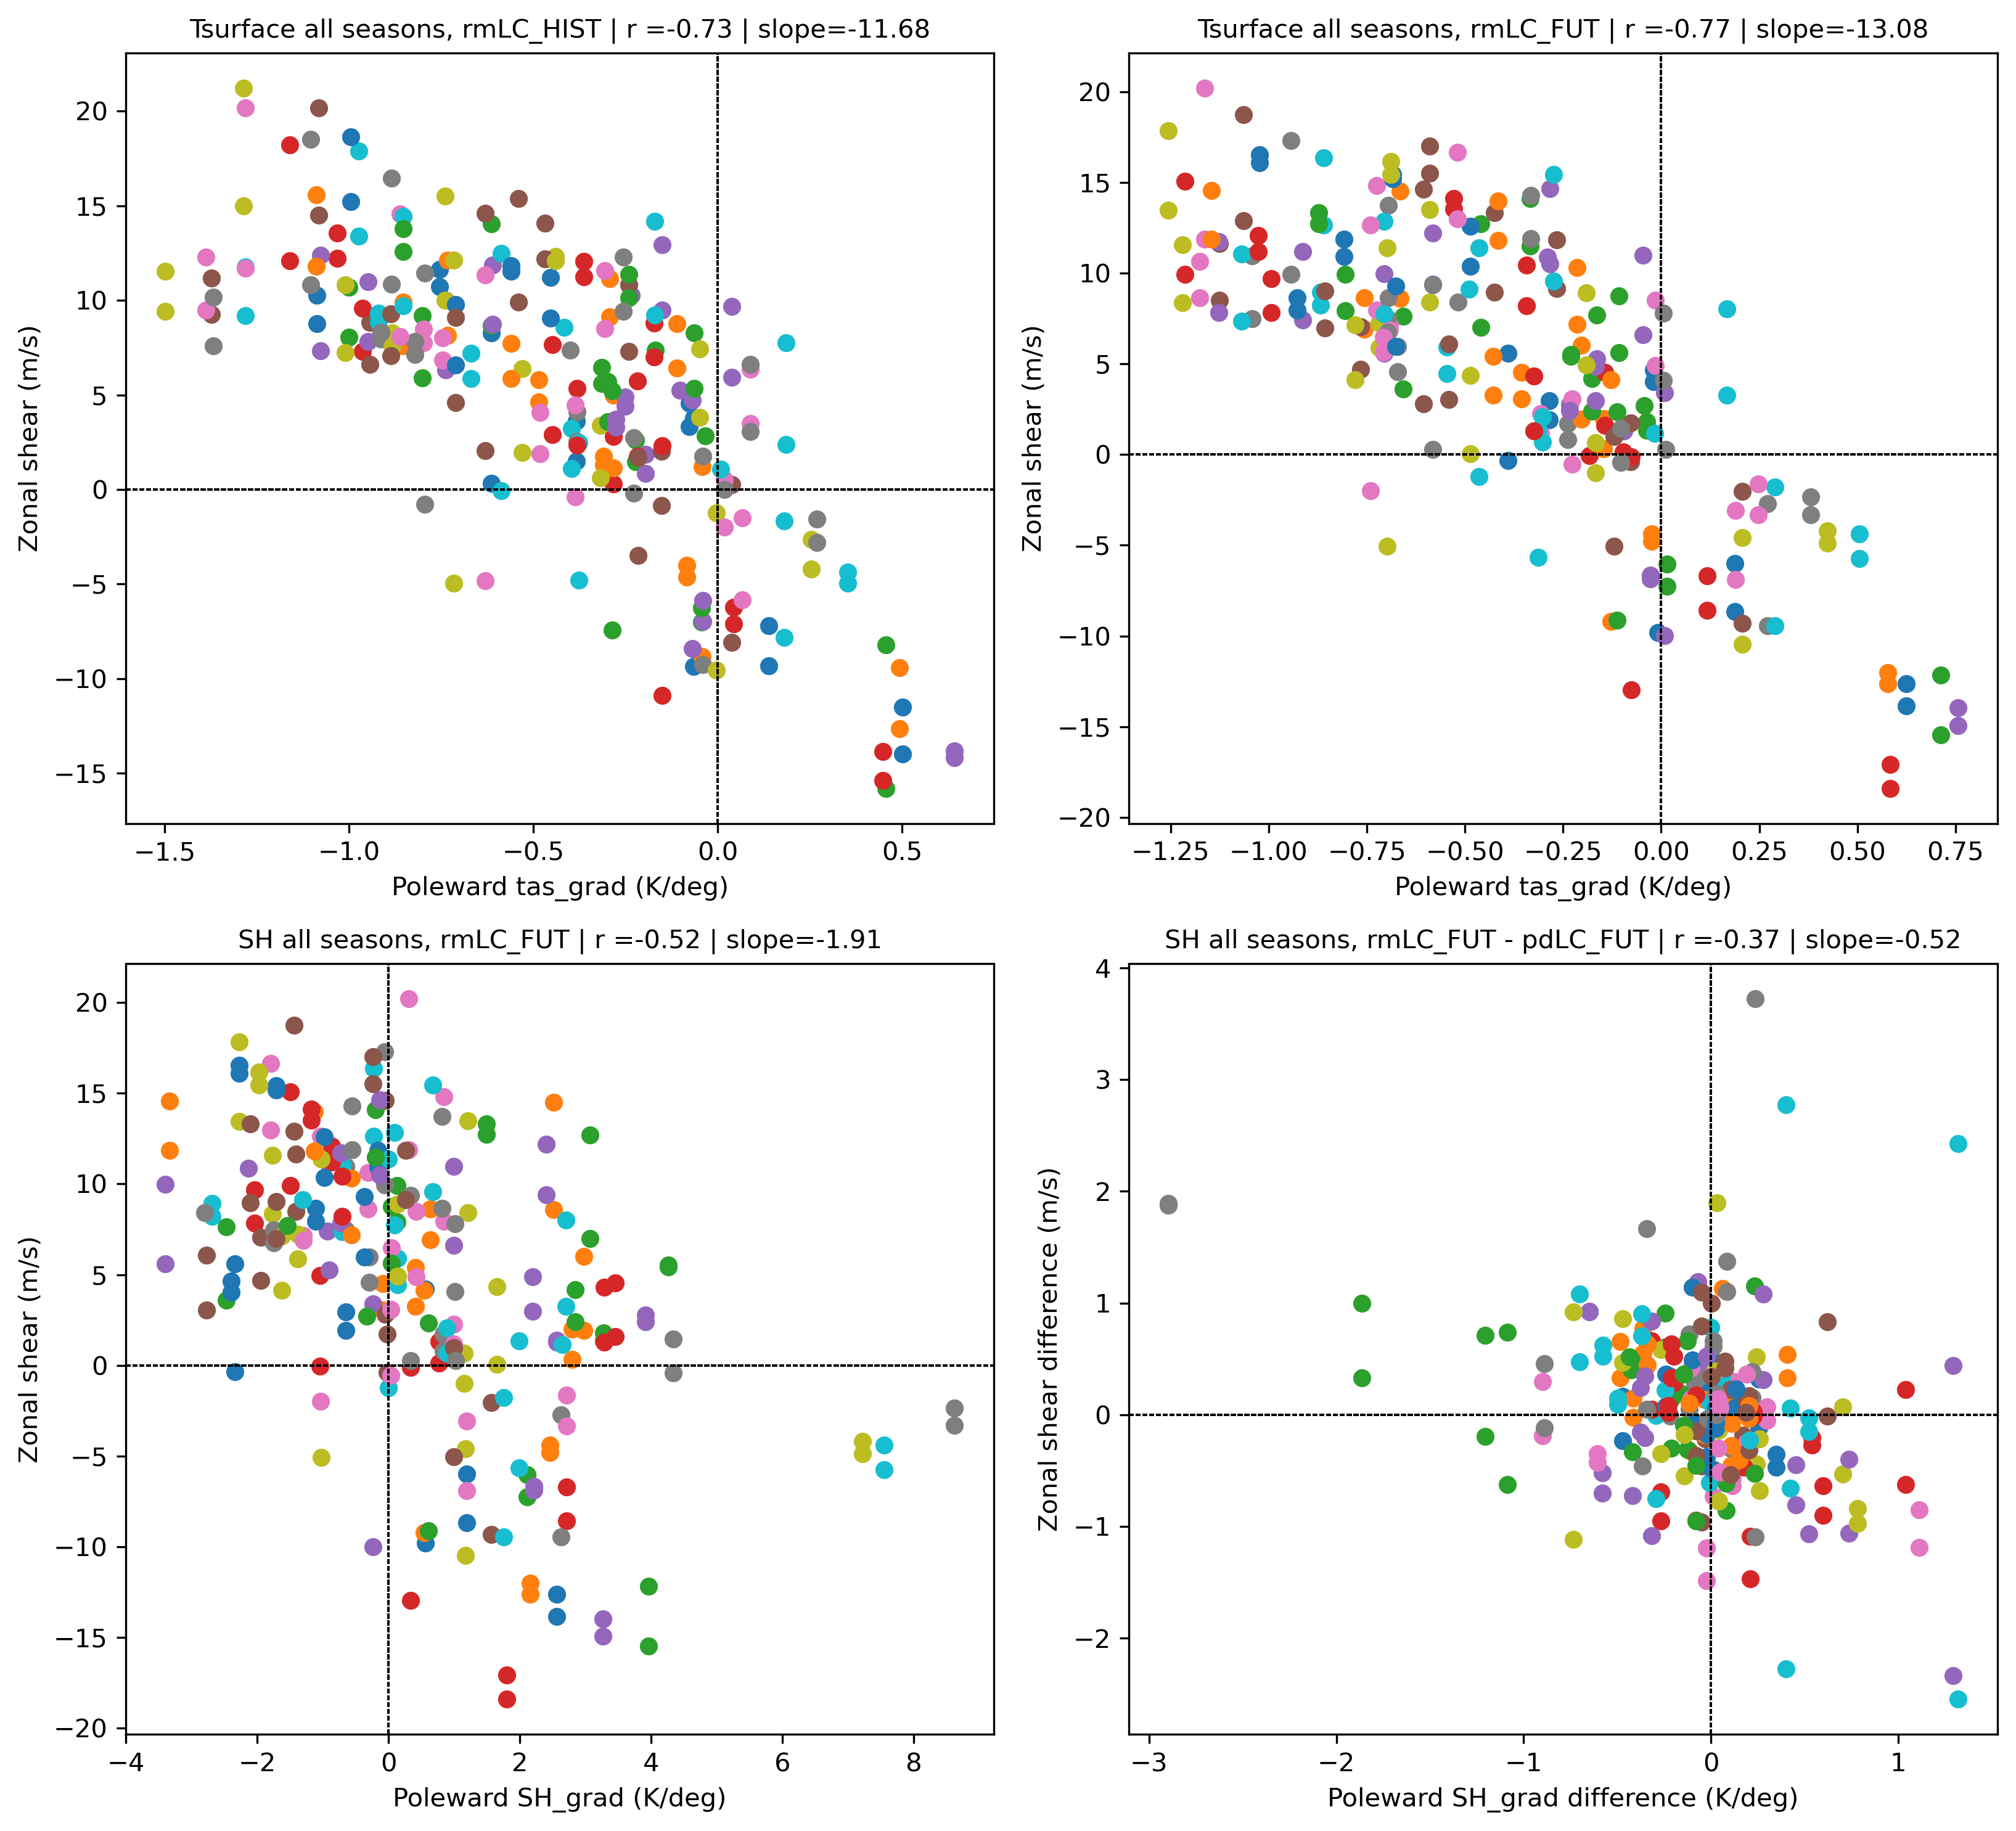

In [271]:
################################ PLOT PER MODEL, ALL Seasons
f = plt.figure(figsize=(11,10), dpi=300)


colors = ['red', 'orange', 'gold', 'brown', 'blue', 'purple', 'violet']
lss = ['solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'dashed']

# for idx, seas in enumerate(['MAM', 'JJA', 'SON', 'DJF']):

tgrad_list = []
shear_list = []
ax = f.add_subplot(221)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        for mtag in ['MAM', 'DJF', 'JJA', 'SON']:  
        
            VAR1='tas'
            VAR2='ushear'
            for idm, model in enumerate(cmip_models):
                hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
                hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

                era_t = hist#-afut
                era_ushear = hist2#-afut2


                box = MREGIONS[reg][6]
                lbox = MREGIONS[reg][0]

                erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
                erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)

                if ids >= 8:
                    erat_poly = erat_poly*-1

        #         if ids >= 8:
        #             erashear_box = erashear_box*-1
                ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg+'_'+model)
                ax.set_xlabel('Poleward tas_grad (K/deg)')
                ax.set_ylabel('Zonal shear (m/s)')
                ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
                ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)

                tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
                shear_list.append(erashear_box.values)
#rval, pval = stats.pearsonr(tgrad_list, shear_list)
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('Tsurface all seasons, rmLC_HIST | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2))+'', fontsize=10)
#plt.legend()

tgrad_list = []
shear_list = []
ax = f.add_subplot(222)
for ids, reg in enumerate((list(MREGIONS.keys()))):
        for mtag in ['MAM', 'DJF', 'JJA', 'SON']:  
    
        
            VAR1='tas'
            VAR2='ushear'

            for idm, model in enumerate(cmip_models):
                hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
                hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

                era_t = afut
                era_ushear = afut2


                box = MREGIONS[reg][6]
                lbox = MREGIONS[reg][0]

                erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
                erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)

                if ids >= 8:
                    erat_poly = erat_poly*-1
        #         if ids >= 8:
        #             erashear_box = erashear_box*-1

                ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
                ax.set_xlabel('Poleward tas_grad (K/deg)')
                ax.set_ylabel('Zonal shear (m/s)')
                ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
                ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
                tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
                shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('Tsurface all seasons, rmLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2))+'', fontsize=10) 


tgrad_list = []
shear_list = []
ax = f.add_subplot(223)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    for mtag in ['MAM', 'DJF', 'JJA', 'SON']:  
        
            VAR1='sh'
            VAR2='ushear'

            for idm, model in enumerate(cmip_models):
                hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
                hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

                era_t = afut
                era_ushear = afut2


                box = MREGIONS[reg][6]
                lbox = MREGIONS[reg][0]

                erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
                erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
                #ipdb.set_trace()

                if ids >= 8:
                    erat_poly = erat_poly*-1

        #         if ids >= 8:
        #             erashear_box = erashear_box*-1

                ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
                ax.set_xlabel('Poleward SH_grad (K/deg)')
                ax.set_ylabel('Zonal shear (m/s)')
                ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
                ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
                tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
                shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('SH all seasons, rmLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 


tgrad_list = []
shear_list = []
ax = f.add_subplot(224)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
    for mtag in ['MAM', 'DJF', 'JJA', 'SON']:  
        
            VAR1='sh'
            VAR2='ushear'

            for idm, model in enumerate(cmip_models):
                hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
                hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

                era_t = fut-afut
                era_ushear = fut2-afut2


                box = MREGIONS[reg][6]
                lbox = MREGIONS[reg][0]

                erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
                erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
                #ipdb.set_trace()

                if ids >= 8:
                    erat_poly = erat_poly*-1

        #         if ids >= 8:
        #             erashear_box = erashear_box*-1
                #ipdb.set_trace()


                ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)


                erashear_box.values[erashear_box>1.5] = np.nan
                ax.set_xlabel('Poleward SH_grad difference (K/deg)')
                ax.set_ylabel('Zonal shear difference (m/s)')
                ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
                ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
                tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
                shear_list.append(erashear_box.values)
    pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('SH all seasons, rmLC_FUT - pdLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 
print(p)

plt.tight_layout()
f.savefig(cnst.FIGS+'/LMCS/CMIP_LS3MIP/LS3MIP-rmLC-pdLC/relationships_scatter/CMIP_shear_Tgradient_relationship_climMean_AllSeasons_separateModel.jpg')

0.004106579932515828


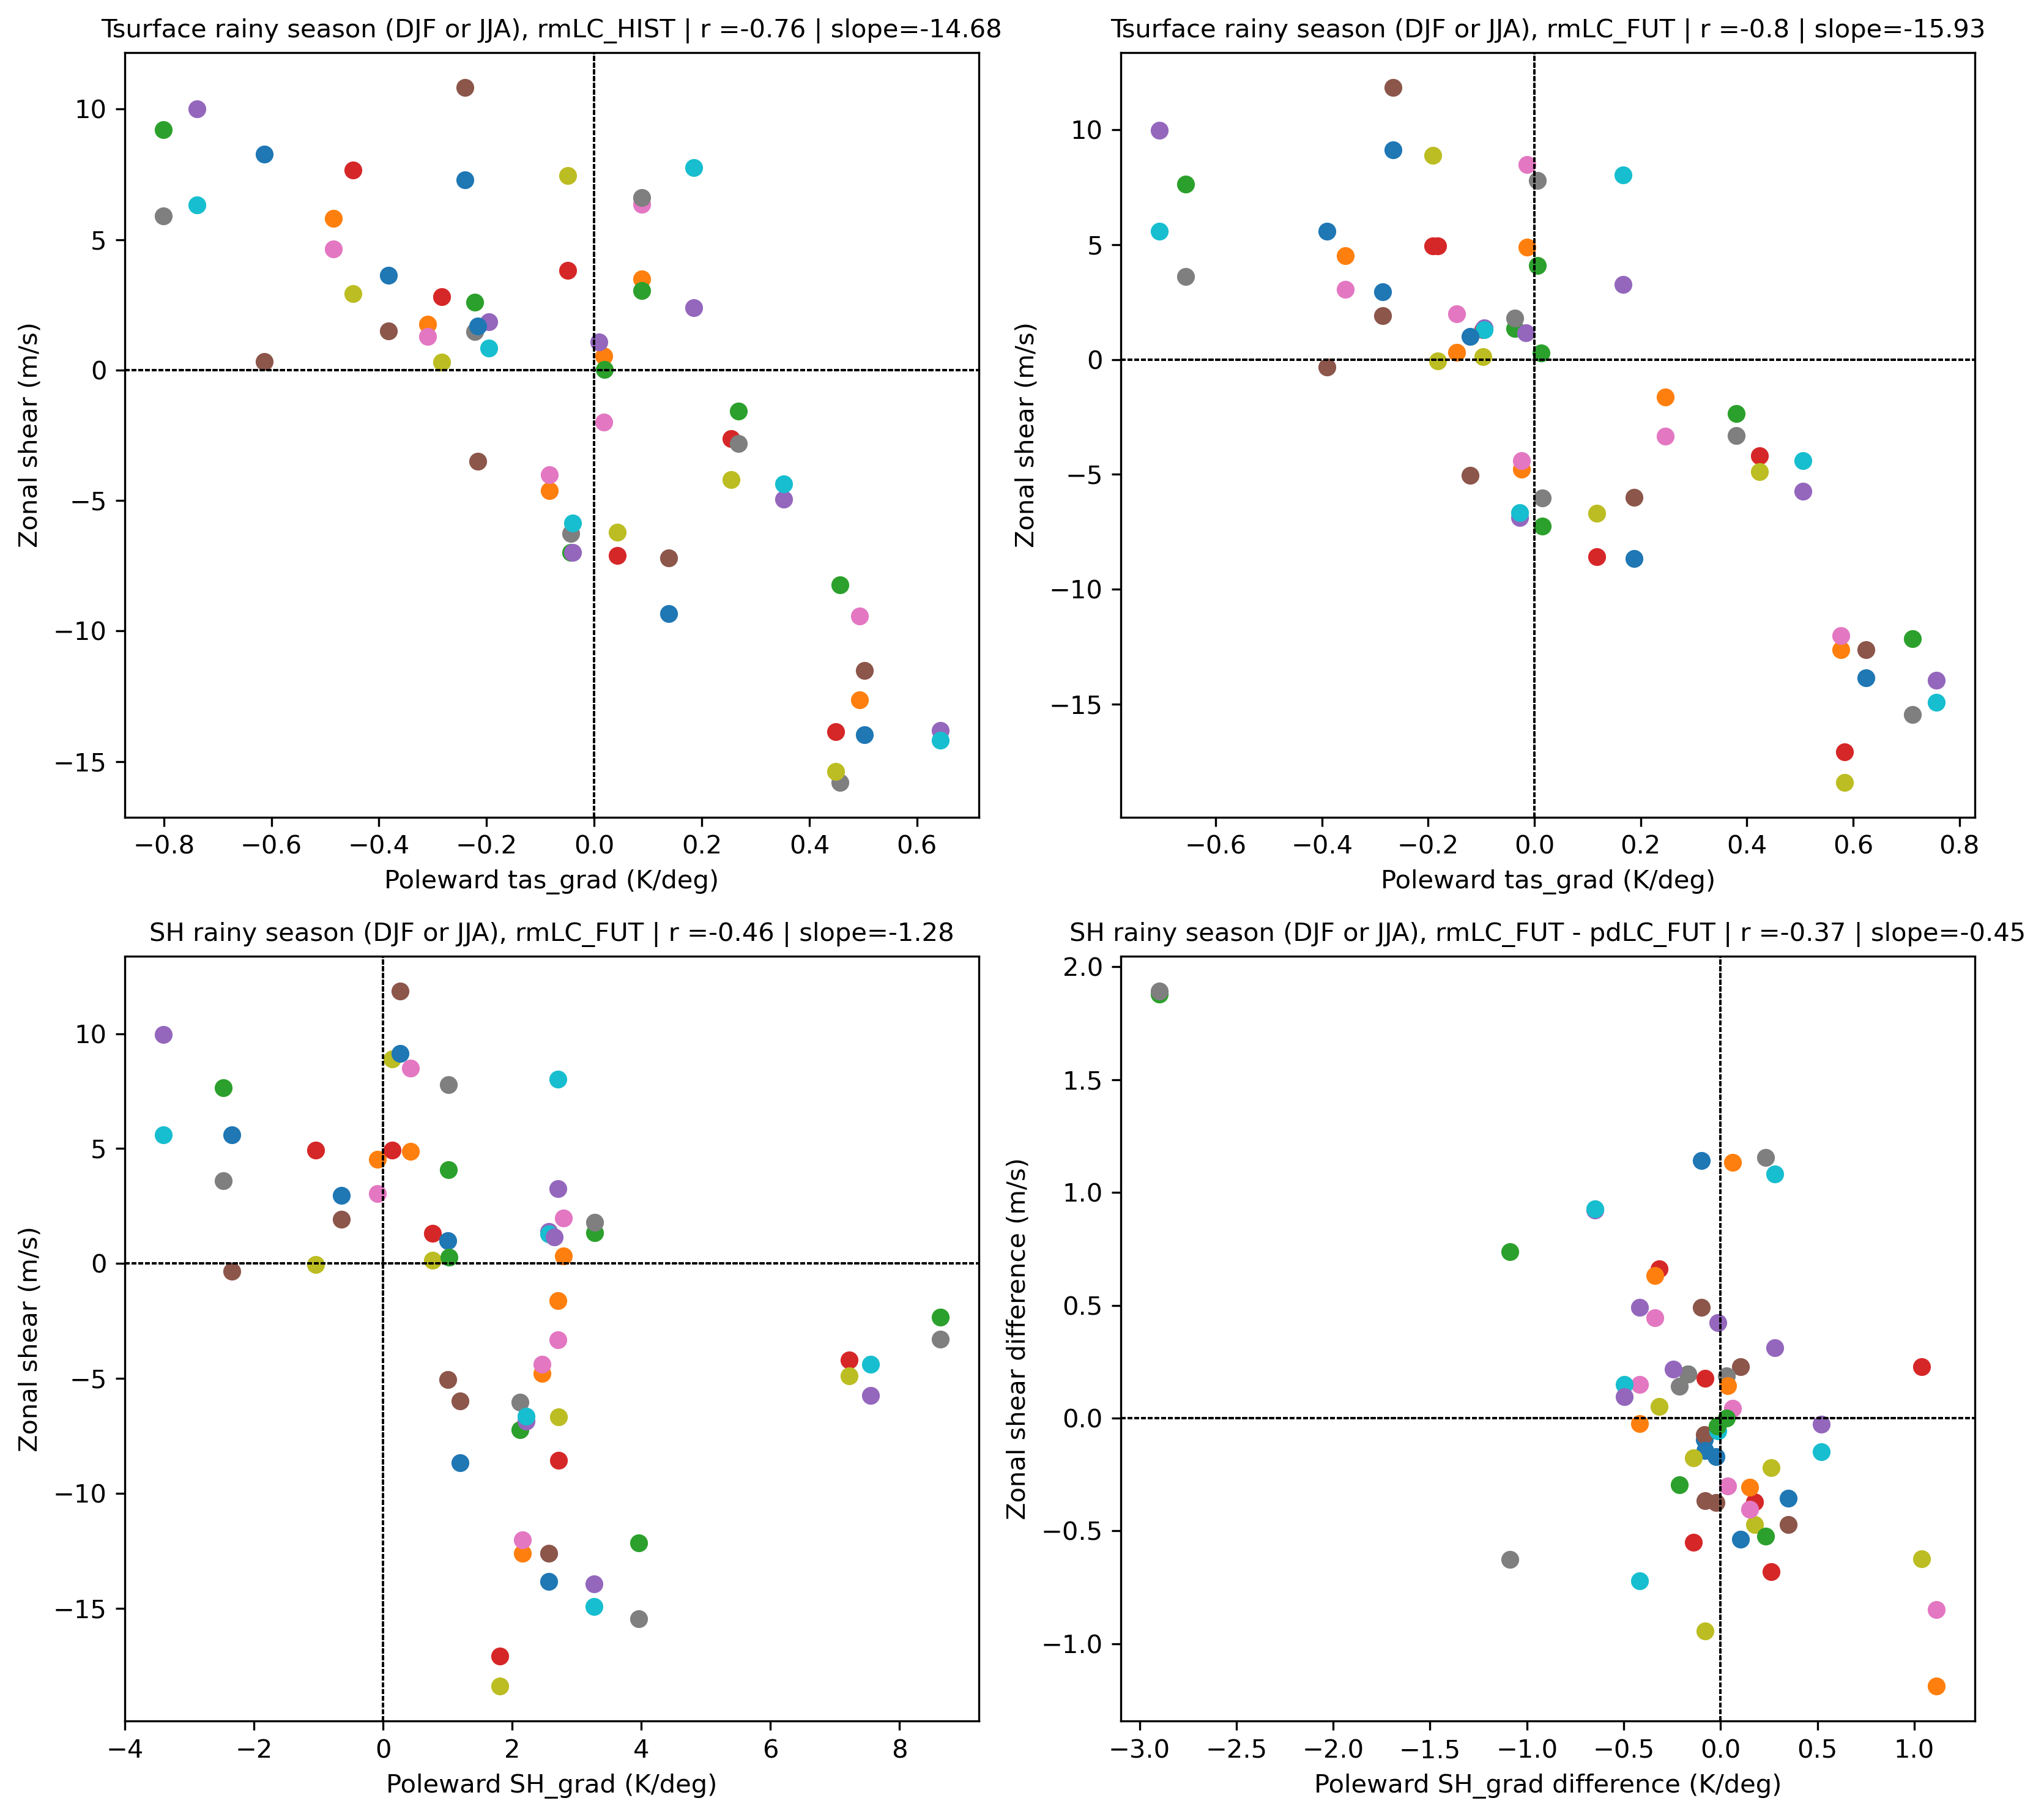

In [272]:
################################ PLOT PER MODEL, rainy season only

f = plt.figure(figsize=(11,10), dpi=300)


colors = ['red', 'orange', 'gold', 'brown', 'blue', 'purple', 'violet']
lss = ['solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'dashed']

# for idx, seas in enumerate(['MAM', 'JJA', 'SON', 'DJF']):

tgrad_list = []
shear_list = []
ax = f.add_subplot(221)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        mtag = MREGIONS[reg][8]
        
        VAR1='tas'
        VAR2='ushear'
        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

            era_t = hist#-afut
            era_ushear = hist2#-afut2


            box = MREGIONS[reg][6]
            lbox = MREGIONS[reg][0]

            erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
            erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)

            if ids >= 8:
                erat_poly = erat_poly*-1

    #         if ids >= 8:
    #             erashear_box = erashear_box*-1
            ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg+'_'+model)
            ax.set_xlabel('Poleward tas_grad (K/deg)')
            ax.set_ylabel('Zonal shear (m/s)')
            ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
            ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)

            tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
            shear_list.append(erashear_box.values)
#rval, pval = stats.pearsonr(tgrad_list, shear_list)
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('Tsurface rainy season (DJF or JJA), rmLC_HIST | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2))+'', fontsize=10)
#plt.legend()

tgrad_list = []
shear_list = []
ax = f.add_subplot(222)
for ids, reg in enumerate((list(MREGIONS.keys()))):
        mtag = MREGIONS[reg][8]
    
        
        VAR1='tas'
        VAR2='ushear'
        
        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

            era_t = afut
            era_ushear = afut2


            box = MREGIONS[reg][6]
            lbox = MREGIONS[reg][0]

            erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
            erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)

            if ids >= 8:
                erat_poly = erat_poly*-1
    #         if ids >= 8:
    #             erashear_box = erashear_box*-1

            ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
            ax.set_xlabel('Poleward tas_grad (K/deg)')
            ax.set_ylabel('Zonal shear (m/s)')
            ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
            ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
            tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
            shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('Tsurface rainy season (DJF or JJA), rmLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2))+'', fontsize=10) 


tgrad_list = []
shear_list = []
ax = f.add_subplot(223)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        mtag = MREGIONS[reg][8]  

        
        VAR1='sh'
        VAR2='ushear'
        
        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

            era_t = afut
            era_ushear = afut2


            box = MREGIONS[reg][6]
            lbox = MREGIONS[reg][0]

            erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
            erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
            #ipdb.set_trace()

            if ids >= 8:
                erat_poly = erat_poly*-1

    #         if ids >= 8:
    #             erashear_box = erashear_box*-1

            ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
            ax.set_xlabel('Poleward SH_grad (K/deg)')
            ax.set_ylabel('Zonal shear (m/s)')
            ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
            ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
            tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
            shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('SH rainy season (DJF or JJA), rmLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 


tgrad_list = []
shear_list = []
ax = f.add_subplot(224)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        mtag = MREGIONS[reg][8]

        
        VAR1='sh'
        VAR2='ushear'
        
        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

            era_t = fut-afut
            era_ushear = fut2-afut2


            box = MREGIONS[reg][6]
            lbox = MREGIONS[reg][0]

            erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
            erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
            #ipdb.set_trace()

            if ids >= 8:
                erat_poly = erat_poly*-1

    #         if ids >= 8:
    #             erashear_box = erashear_box*-1
            #ipdb.set_trace()


            ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
            
                        
            erashear_box.values[erashear_box>1.5] = np.nan
            ax.set_xlabel('Poleward SH_grad difference (K/deg)')
            ax.set_ylabel('Zonal shear difference (m/s)')
            ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
            ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
            tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
            shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('SH rainy season (DJF or JJA), rmLC_FUT - pdLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 
print(p)

plt.tight_layout()
f.savefig(cnst.FIGS+'/LMCS/CMIP_LS3MIP/LS3MIP-rmLC-pdLC/relationships_scatter/CMIP_shear_Tgradient_relationship_climMean_RainyMonths_separateModel.jpg')

0.004106579932515828
0.00032856024365695506


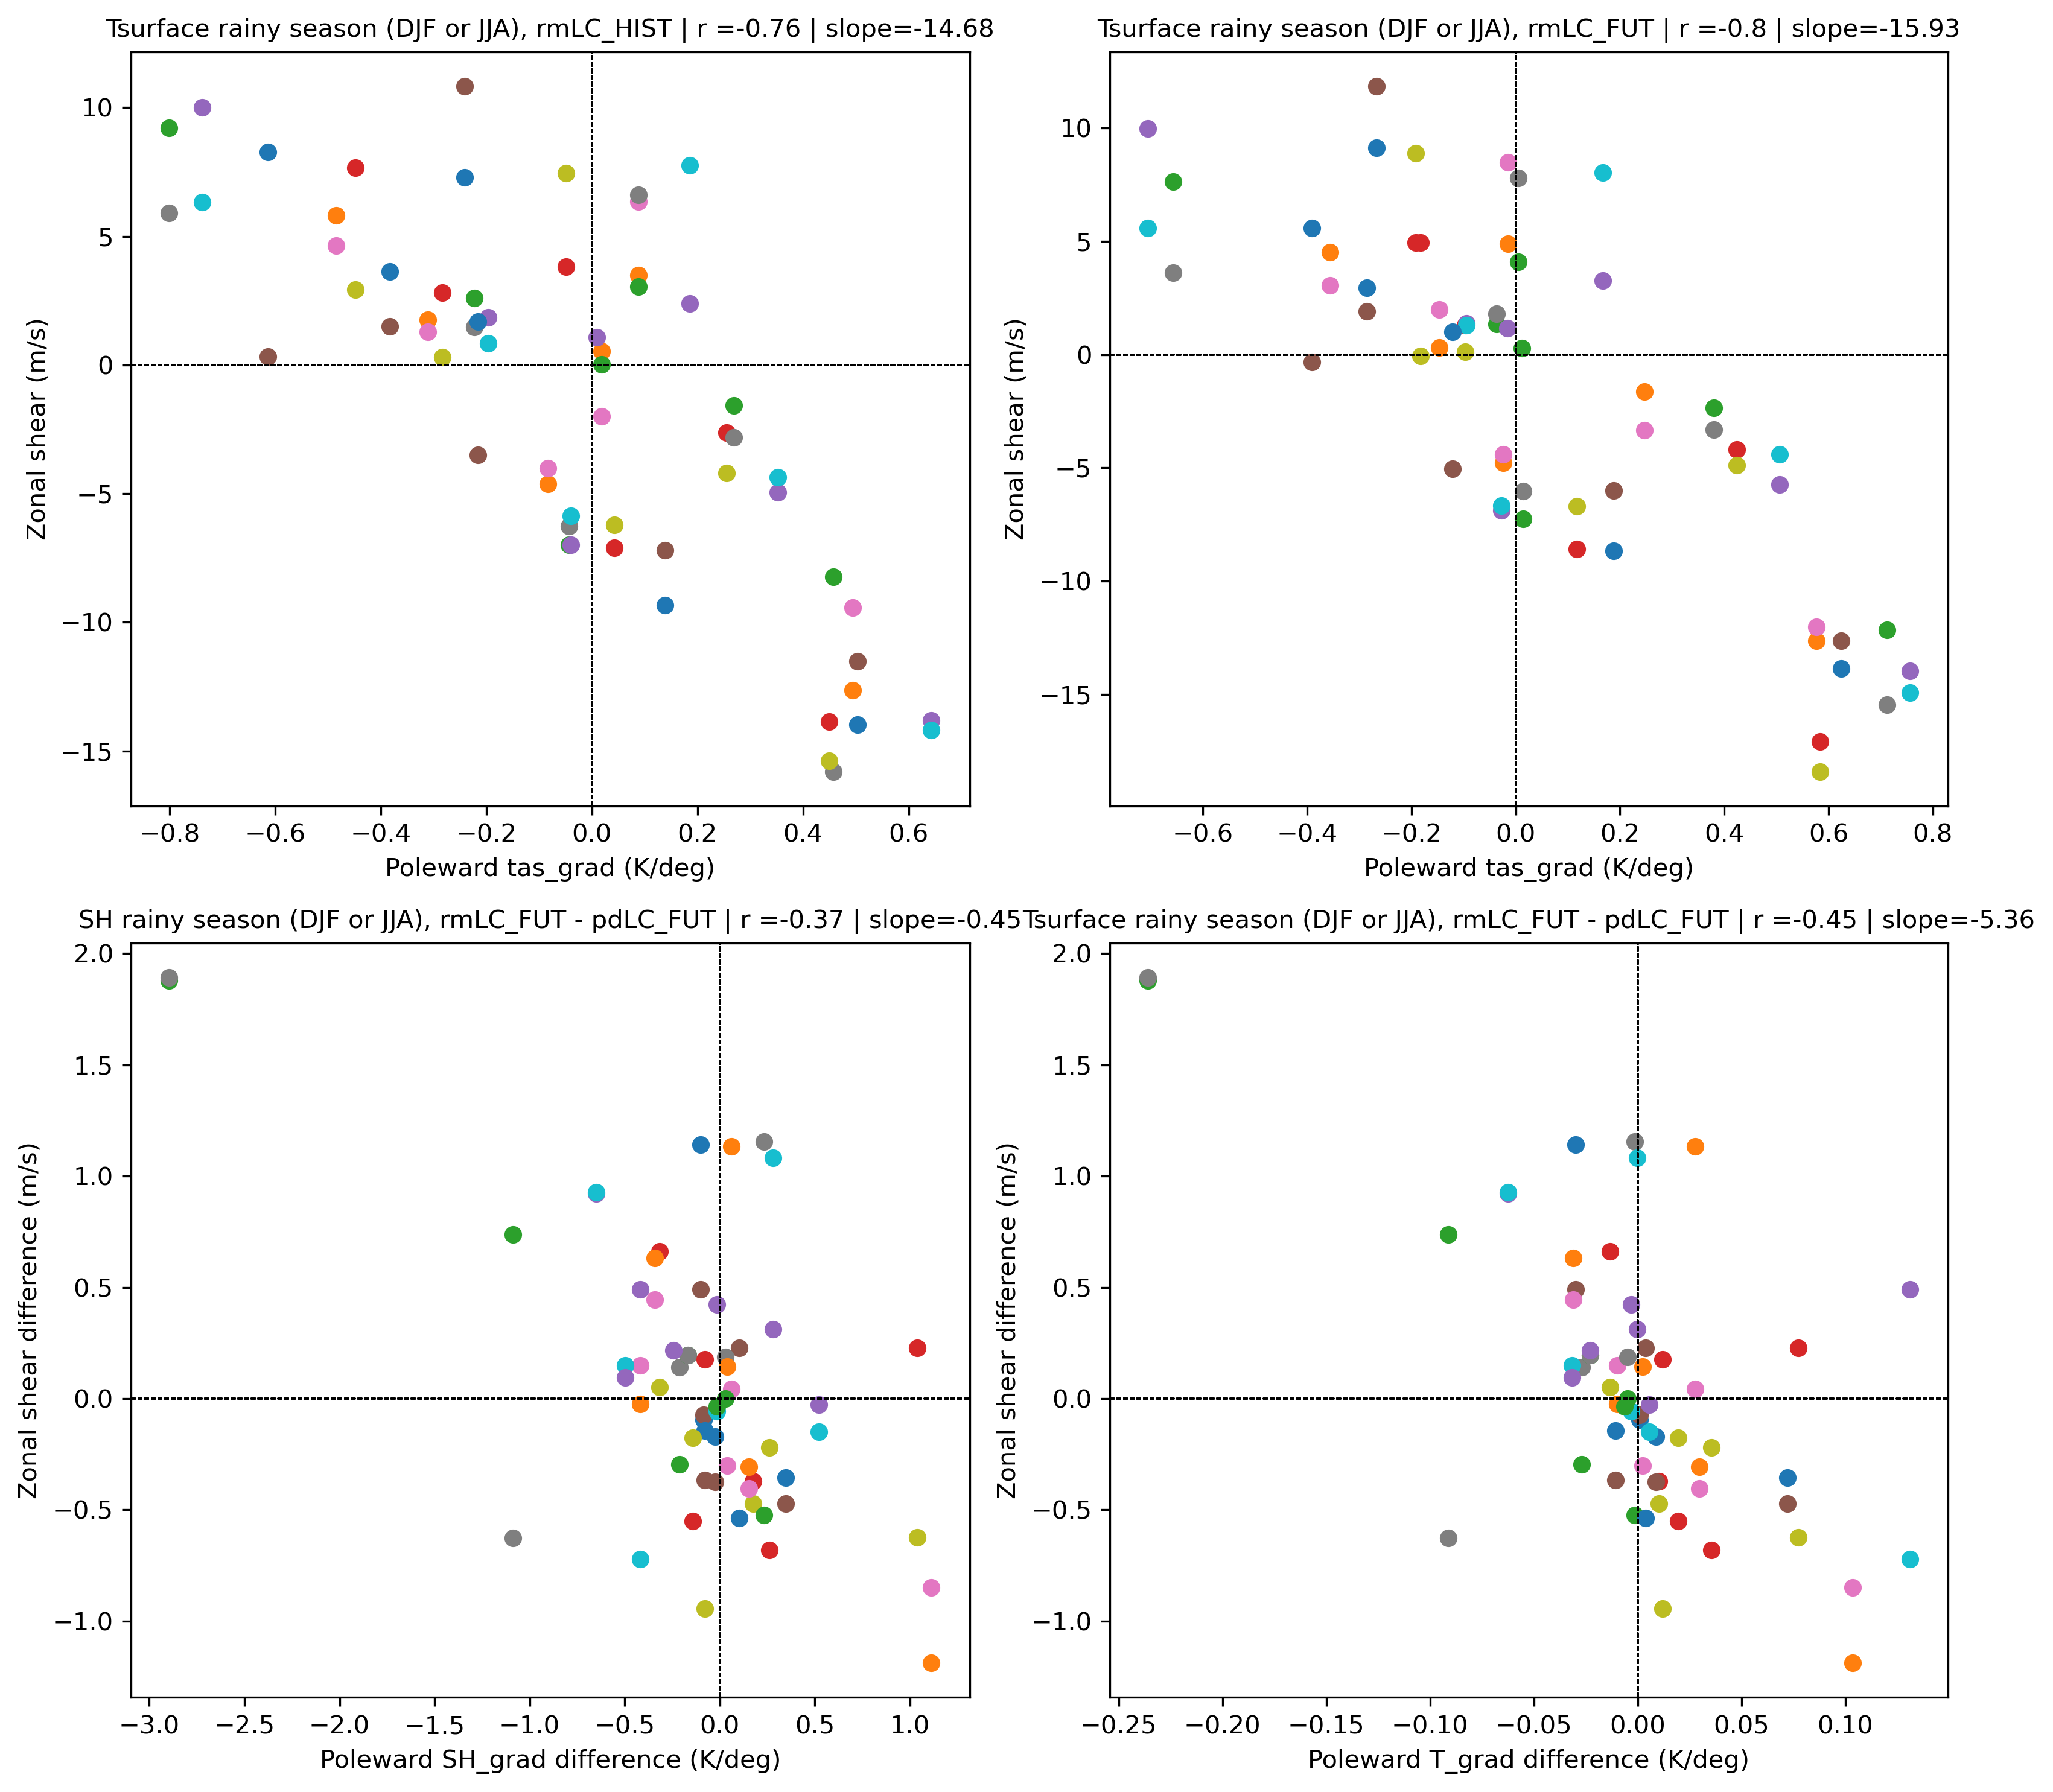

In [89]:
################################ PLOT PER MODEL, rainy season only

f = plt.figure(figsize=(11,10), dpi=300)


colors = ['red', 'orange', 'gold', 'brown', 'blue', 'purple', 'violet']
lss = ['solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'dashed']

# for idx, seas in enumerate(['MAM', 'JJA', 'SON', 'DJF']):

tgrad_list = []
shear_list = []
ax = f.add_subplot(221)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        mtag = MREGIONS[reg][8]
        
        VAR1='tas'
        VAR2='ushear'
        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

            era_t = hist#-afut
            era_ushear = hist2#-afut2


            box = MREGIONS[reg][6]
            lbox = MREGIONS[reg][0]

            erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
            erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)

            if ids >= 8:
                erat_poly = erat_poly*-1

    #         if ids >= 8:
    #             erashear_box = erashear_box*-1
            ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg+'_'+model)
            ax.set_xlabel('Poleward tas_grad (K/deg)')
            ax.set_ylabel('Zonal shear (m/s)')
            ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
            ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)

            tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
            shear_list.append(erashear_box.values)
#rval, pval = stats.pearsonr(tgrad_list, shear_list)
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('Tsurface rainy season (DJF or JJA), rmLC_HIST | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2))+'', fontsize=10)
#plt.legend()

tgrad_list = []
shear_list = []
ax = f.add_subplot(222)
for ids, reg in enumerate((list(MREGIONS.keys()))):
        mtag = MREGIONS[reg][8]
    
        
        VAR1='tas'
        VAR2='ushear'
        
        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

            era_t = afut
            era_ushear = afut2


            box = MREGIONS[reg][6]
            lbox = MREGIONS[reg][0]

            erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
            erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)

            if ids >= 8:
                erat_poly = erat_poly*-1
    #         if ids >= 8:
    #             erashear_box = erashear_box*-1

            ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
            ax.set_xlabel('Poleward tas_grad (K/deg)')
            ax.set_ylabel('Zonal shear (m/s)')
            ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
            ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
            tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
            shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('Tsurface rainy season (DJF or JJA), rmLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2))+'', fontsize=10) 


tgrad_list = []
shear_list = []
ax = f.add_subplot(223)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        mtag = MREGIONS[reg][8]

        
        VAR1='sh'
        VAR2='ushear'
        
        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

            era_t = fut-afut
            era_ushear = fut2-afut2


            box = MREGIONS[reg][6]
            lbox = MREGIONS[reg][0]

            erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
            erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
            #ipdb.set_trace()

            if ids >= 8:
                erat_poly = erat_poly*-1

    #         if ids >= 8:
    #             erashear_box = erashear_box*-1
            #ipdb.set_trace()


            ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
            
                        
            erashear_box.values[erashear_box>1.5] = np.nan
            ax.set_xlabel('Poleward SH_grad difference (K/deg)')
            ax.set_ylabel('Zonal shear difference (m/s)')
            ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
            ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
            tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
            shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('SH rainy season (DJF or JJA), rmLC_FUT - pdLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 
print(p)


tgrad_list = []
shear_list = []
ax = f.add_subplot(224)
for ids, reg in enumerate((list(MREGIONS.keys()))):
    
        mtag = MREGIONS[reg][8]

        
        VAR1='tas'
        VAR2='ushear'
        
        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)

            era_t = fut-afut
            era_ushear = fut2-afut2


            box = MREGIONS[reg][6]
            lbox = MREGIONS[reg][0]

            erashear_box = era_ushear.sel(lat=slice(box[2],box[3]), lon=slice(box[0],box[1])).mean(['lon','lat']).squeeze()
            erat_poly = era_t.sel(lat=slice(lbox[2],lbox[3]), lon=slice(lbox[0],lbox[1])).mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
            #ipdb.set_trace()

            if ids >= 8:
                erat_poly = erat_poly*-1

    #         if ids >= 8:
    #             erashear_box = erashear_box*-1
            #ipdb.set_trace()


            ax.scatter(erat_poly['polyfit_coefficients'][0], erashear_box, label=reg)
            
                        
            erashear_box.values[erashear_box>1.5] = np.nan
            ax.set_xlabel('Poleward T_grad difference (K/deg)')
            ax.set_ylabel('Zonal shear difference (m/s)')
            ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
            ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
            tgrad_list.append(erat_poly['polyfit_coefficients'][0].values)
            shear_list.append(erashear_box.values)
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[np.isfinite(shear_list)], np.array(shear_list)[np.isfinite(shear_list)])
plt.title('Tsurface rainy season (DJF or JJA), rmLC_FUT - pdLC_FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 
print(p)

plt.tight_layout()
f.savefig(cnst.FIGS+'/LMCS/CMIP_LS3MIP/LS3MIP-rmLC-pdLC/relationships_scatter/CMIP_shear_Tgradient_relationship_climMean_RainyMonths_separateModel_tasDiff.jpg')